#### All the features have already been extracted from the sources

In [1]:
# Importing necessary packages:
import pandas as pd
import numpy as np
import netCDF4
import datetime
import os
from bisect import bisect_left
import random
import xgboost as xgb
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier

from utils import (
    drop_constantcolumns,
    take_closest,
    catencoder_dict_generator,
    catencoder,
    evaluate_model,
    evaluate_grid,
    evaluate_grid2,
    auxmygrid,
    mygrid
)


with open('data/faw20191220_targetpercent.pickle', 'rb') as input:
    faw = pickle.load(input)

/Users/angeldejaen/miniconda3/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


#### FEATURE ENGINEERING:
We create some extra features

In [2]:
faw = faw[faw.cropMain == 'maize']
faw['instant_yearly'] = (pd.to_datetime(faw.date, format = '%Y%m%d') - pd.to_datetime('20180101', format = '%Y%m%d')).dt.days# faw.instant.copy()
faw.loc[faw.instant_yearly > 364, 'instant_yearly'] = faw.loc[faw.instant_yearly > 364, 'instant_yearly'] - 365

In [3]:
faw = faw[(faw.target != 0) & (faw.target != 100)]

In [4]:
to_drop_list = ['date', 'scouting', 'traps', 'cropPlantingDate', 'trapsCount', 'trapsConfirmedFAW',
                'trapsSuspectedFAW', 'trapsOtherSpecies', 'scoutingPlantsChecked', 'scoutingPlantsFAW',
                'scoutingPercentageFAW', 'fawCropDamage', 'fawCobDamage', 'fawNaturalEnemies', 'fawDeadLarvae',
                'fawControlUndertaken', 'fawControlChemicalPesticideName', 'fawControlChemicalPesticideLitres',
                'scoutingStageFAW', 'fawCurrentDamage', 'fawPreviousDamage', 'fawControlLocalTypes',
                'fawControlBiopesticideName', 'fawControlBiopesticideLitres', 'fawLarvaeKilledByNaturalEnemies',
                'lat_rounded', 'lon_rounded', 'latitude_y', 'longitude_y', 'latitude_x', 'longitude_x',
                'original_date', 'ID', 'region', 'country', 'userCountry', 'locationName',
                'ISSOIL', 'SEQ', 'cropMain', 'daysLastRain', 'Tair_f_tavg_mean',
                'RadT_tavg_mean', 'inspections_around_positive', 'inspections_around_count',
                'S_OC', 'S_BULK_DENSITY', 'S_GRAVEL', 'S_SAND', 'S_SILT', 'S_CLAY',
                'S_BULK_DENSITY', 'S_OC', 'S_PH_H2O', 'S_CEC_CLAY', 'S_CEC_SOIL',
                'S_BS', 'S_TEB', 'S_CACO3', 'S_CASO4', 'S_ESP', 'S_ECE',
                'PHASE1', 'REF_DEPTH', 'SHARE', 'cropFieldSize', 'Psurf_f_tavg_mean']

#### CHECKING THE SIZE OF THE SAMPLES CHOSEN FOR TRAIN - VALIDATION

In [5]:
print(faw.shape[0])

print(faw[(faw.longitude_x > 26) & (faw.longitude_x < 33) & (faw.date >= '20190101')].shape[0])
print(faw[(faw.longitude_x <= -1) & (faw.date >= '20190101')].shape[0])
print(faw[(faw.longitude_x >= 35.5) & (faw.date >= '20190101')].shape[0])
print(faw[((faw.longitude_x <= 26) | (faw.longitude_x >= 33)) & (faw.date < '20190101')].shape[0])
print(faw[(faw.longitude_x > -1) & (faw.date < '20190101')].shape[0])
print(faw[(faw.longitude_x < 35.5) & (faw.date < '20190101')].shape[0])

6020
884
1262
487
1794
1831
1244


In [6]:
# We cross validate making sure that the validation set has crops from a different region and a different time
# Validation Set: between 26 and 33 grads of longitude, 2019
# Training Set: Out of the validation region, 2018

faw1 = faw.copy()

faw1['cv5'] = [1 if ((lon > 26) & (lon < 33)) else 0 for lon in faw1.longitude_x]
faw1.loc[(faw1.cv5 == 0) & (faw1.date < '20190101'), 'cv5'] = 2
faw1.loc[(faw1.cv5 == 1) & (faw1.date >= '20190101'), 'cv5'] = 3

faw1.drop(to_drop_list,
         axis=1, inplace=True)

enc_dict = catencoder_dict_generator(pddf=faw1, threshold=0.02)

faw1 = catencoder(pddf=faw1, enc_dict=enc_dict, idcol='id4')

In [7]:
randomgrid_global = mygrid([[5, 8, 11, 14],
                            [1, 3, 7, 13],
                            [0.5, 0.7, 0.9],
                            [0.5, 0.7, 0.9]], n_iter=300)

# Adapting the dataframe to our functions format:
faw1.rename(columns={'id4': 'user_id', 'cv5': 'folds_column'}, inplace=True)

metric = 'mae'

In [8]:
evaluations_global = evaluate_grid(gridsearch_params=randomgrid_global, tr=faw1, metric=metric,
                                  maximize_metric=None, objective_type=None, tr_fcolumnvalue=2,
                                   eval_fcolumnvalue=3)

print(evaluations_global)

[8, 1, 0.5, 0.9, 53.0]


In [9]:
max_depth_grid = list(range(evaluations_global[0]-2,
                            evaluations_global[0]+3,
                            1)) if evaluations_global[0] > 3 else list(range(evaluations_global[0],
                                                                             evaluations_global[0]+4))
min_child_weight_grid = list(range(evaluations_global[1]-2,
                                   evaluations_global[1]+3,
                                   2)) if evaluations_global[1] > 2 else [1, 2]

subsample_grid = [evaluations_global[2] - 0.1,
                  evaluations_global[2],
                  evaluations_global[2] + 0.1] if evaluations_global[2] != 0.9 else [0.8, 0.9, 0.96]
                                                                              
colsample_bytree_grid = [evaluations_global[3] - 0.1,
                         evaluations_global[3],
                         evaluations_global[3] + 0.1] if evaluations_global[3] != 0.9 else [0.8, 0.9, 0.96]


randomgrid_local = [
    (max_depth, min_child_weight, subsample, colsample_bytree)
    for max_depth in max_depth_grid
    for min_child_weight in min_child_weight_grid
    for subsample in subsample_grid
    for colsample_bytree in colsample_bytree_grid
]

evaluations_local = evaluate_grid(gridsearch_params=randomgrid_local, tr=faw1, metric=metric,
                                  maximize_metric=None, objective_type=None, tr_fcolumnvalue=2,
                                  eval_fcolumnvalue=3)
print(evaluations_local)

[8, 1, 0.5, 0.9, 53.0]


In [10]:
(faw1.target - faw1.target.median()).abs().mean()

19.056478405315616

In [11]:
# We calculate the mae using the median as a predictor (which is the best constant predictor possible for
# minimizing the mae)
(faw1[faw1.folds_column == 3].target - faw1[faw1.folds_column == 2].target.median()).abs().mean()

17.493212669683256

In [12]:

tr = faw1[faw1.folds_column == 2]
tuple_params = evaluations_local

evals = faw1[faw1.folds_column == 3]

objective_type = 'reg:linear'

xgtrain = xgb.DMatrix(tr.drop(['user_id', 'folds_column', 'target'], axis=1),
                      label = tr.target.astype(int),
                      feature_names = np.delete(tr.columns.values,
                                                np.where(np.isin(tr.columns.values,
                                                                 ['user_id', 'folds_column', 'target'])))
                     )
xgevals = xgb.DMatrix(evals.drop(['user_id', 'folds_column', 'target'], axis=1),
                      label = evals.target.astype(int),
                      feature_names = np.delete(evals.columns.values,
                                                np.where(np.isin(evals.columns.values,
                                                                 ['user_id', 'folds_column', 'target'])))
                     )

xgb_param = {}

xgb_param['gamma'] = 0
xgb_param['learning_rate'] = 0.1
xgb_param['n_estimators'] = int(tuple_params[4] if tuple_params[4] > 0 else 1)
xgb_param['booster'] = 'gbtree'
xgb_param['objective'] = objective_type
xgb_param["eval_metric"] = metric
xgb_param['silent'] = 1
xgb_param['seed'] = 499
xgb_param['base_score'] = 0.5

xgb_param['max_depth'] = tuple_params[0]
xgb_param['min_child_weight'] = tuple_params[1]
xgb_param['subsample'] = tuple_params[2]
xgb_param['colsample_bytree'] = tuple_params[3]

XGB_model = xgb.train(xgb_param,
                      xgtrain,
                      num_boost_round=int(tuple_params[4] if tuple_params[4] > 0 else 1),
                      evals=[(xgtrain, 'train'),
                             (xgevals,'eval')])

[0]	train-mae:35.0702	eval-mae:25.9212
[1]	train-mae:31.8666	eval-mae:24.1302
[2]	train-mae:29.0294	eval-mae:22.6616
[3]	train-mae:26.5901	eval-mae:21.1532
[4]	train-mae:24.4775	eval-mae:20.2087
[5]	train-mae:22.5886	eval-mae:18.9831
[6]	train-mae:20.958	eval-mae:18.5458
[7]	train-mae:19.5454	eval-mae:18.0248
[8]	train-mae:18.2863	eval-mae:17.7975
[9]	train-mae:17.202	eval-mae:17.5268
[10]	train-mae:16.2568	eval-mae:17.4342
[11]	train-mae:15.3786	eval-mae:17.2588
[12]	train-mae:14.643	eval-mae:17.1409
[13]	train-mae:13.9375	eval-mae:17.0776
[14]	train-mae:13.2969	eval-mae:17.1135
[15]	train-mae:12.6913	eval-mae:17.0732
[16]	train-mae:12.2406	eval-mae:17.0552
[17]	train-mae:11.7671	eval-mae:17.0556
[18]	train-mae:11.3901	eval-mae:17.0394
[19]	train-mae:11.0596	eval-mae:17.0646
[20]	train-mae:10.7599	eval-mae:17.2406
[21]	train-mae:10.4741	eval-mae:17.2341
[22]	train-mae:10.1338	eval-mae:17.3205
[23]	train-mae:9.89625	eval-mae:17.3404
[24]	train-mae:9.62058	eval-mae:17.3687
[25]	train-ma

In [13]:
feats = pd.DataFrame({'Feature': list(XGB_model.get_score(importance_type='total_gain').keys()),
                      'Total_Gain': list(XGB_model.get_score(importance_type='total_gain').values())})

feats.sort_values(by='Total_Gain', ascending=False, inplace=True)

print(feats.head(25))

                      Feature     Total_Gain
8                         age  445941.087963
0                   AWC_CLASS  432926.925341
5    SoilMoi00_10cm_tavg_mean  432320.020555
4            Qair_f_tavg_mean  362880.815174
9   SoilTemp00_10cm_tavg_mean  316519.241879
19          Rainf_f_tavg_mean  278751.431771
12             instant_yearly  251188.314049
13  Wind_f_tavg_mean_lastdays  209822.315117
17           Wind_f_tavg_mean  203821.576383
1                      T_CLAY  191510.804546
22    inspections_around_rate  157759.359400
28            rainAmount_rest   97127.038674
44            cropHealth_poor   84377.538443
10   cropIrrigation_irrigated   72627.846931
41                   T_PH_H2O   68606.658966
2                  T_CEC_CLAY   67991.831857
3                       T_TEB   66051.105005
6             cropHealth_good   57283.179160
16                     T_SILT   50087.378781
32          cropHealth_medium   49074.226090
29                   DRAINAGE   44026.057276
11        

In [14]:
feats2 = pd.DataFrame({'Feature': list(XGB_model.get_score(importance_type='weight').keys()),
                      'Weight': list(XGB_model.get_score(importance_type='weight').values())})

feats2.sort_values(by='Weight', ascending=False, inplace=True)

print(feats2.head(25))

                      Feature  Weight
8                         age    1130
4            Qair_f_tavg_mean     439
9   SoilTemp00_10cm_tavg_mean     377
19          Rainf_f_tavg_mean     371
5    SoilMoi00_10cm_tavg_mean     361
22    inspections_around_rate     346
12             instant_yearly     314
13  Wind_f_tavg_mean_lastdays     290
17           Wind_f_tavg_mean     279
29                   DRAINAGE      90
0                   AWC_CLASS      73
14                  T_TEXTURE      69
16                     T_SILT      67
23                   T_GRAVEL      65
18                     T_SAND      63
26       cropStage_vegetative      58
32          cropHealth_medium      55
11             T_BULK_DENSITY      49
25         cropFertilizer_yes      47
3                       T_TEB      45
2                  T_CEC_CLAY      43
15     cropStage_reproductive      41
1                      T_CLAY      40
31     cropIrrigation_rainFed      39
6             cropHealth_good      39


In [15]:
auxdf = faw1[feats.Feature.head(20)]

corr = auxdf.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,AWC_CLASS,SoilMoi00_10cm_tavg_mean,Qair_f_tavg_mean,SoilTemp00_10cm_tavg_mean,Rainf_f_tavg_mean,instant_yearly,Wind_f_tavg_mean_lastdays,Wind_f_tavg_mean,T_CLAY,inspections_around_rate,rainAmount_rest,cropHealth_poor,cropIrrigation_irrigated,T_PH_H2O,T_CEC_CLAY,T_TEB,cropHealth_good,T_SILT,cropHealth_medium
age,1.000000,-0.108810,-0.017230,-0.249569,-0.350977,-0.116606,-0.043440,-0.145622,-0.156788,0.136185,0.037674,0.004119,0.008023,0.020198,-0.029458,0.021573,0.017196,0.023538,0.050548,-0.026704
AWC_CLASS,-0.108810,1.000000,-0.165625,0.030299,0.319447,-0.067716,0.365746,0.235339,0.254542,-0.450013,-0.012802,0.060371,-0.006856,0.193666,0.412812,0.276366,-0.108039,-0.039605,0.091784,0.041387
SoilMoi00_10cm_tavg_mean,-0.017230,-0.165625,1.000000,0.450275,-0.219600,0.536439,-0.193423,-0.279817,-0.301455,0.383387,-0.036250,0.009605,-0.067479,-0.360706,-0.279395,-0.219783,0.059087,0.091088,0.070392,-0.051252
Qair_f_tavg_mean,-0.249569,0.030299,0.450275,1.000000,0.423404,0.375673,-0.167974,0.073922,0.081577,-0.059881,-0.111755,0.033925,-0.049230,-0.429164,-0.253123,-0.230348,-0.038779,0.007516,-0.089207,0.018854
SoilTemp00_10cm_tavg_mean,-0.350977,0.319447,-0.219600,0.423404,1.000000,-0.054390,0.152733,0.475255,0.507107,-0.355205,-0.100433,0.048362,0.019013,-0.028239,0.196462,0.121888,-0.024675,-0.118738,0.002783,0.103261
Rainf_f_tavg_mean,-0.116606,-0.067716,0.536439,0.375673,-0.054390,1.000000,-0.143625,-0.097164,-0.093657,0.093357,-0.025657,-0.011670,-0.071431,-0.182397,-0.229682,-0.203662,0.016546,0.065027,-0.037426,-0.024293
instant_yearly,-0.043440,0.365746,-0.193423,-0.167974,0.152733,-0.143625,1.000000,0.194036,0.211904,-0.184985,-0.035750,0.023759,0.022488,0.244849,0.307467,0.230151,-0.093577,-0.045789,0.162443,0.031808
Wind_f_tavg_mean_lastdays,-0.145622,0.235339,-0.279817,0.073922,0.475255,-0.097164,0.194036,1.000000,0.943331,-0.281349,-0.108598,0.048158,0.016993,0.064427,0.362262,0.314077,0.089823,-0.063460,0.063967,0.051560
Wind_f_tavg_mean,-0.156788,0.254542,-0.301455,0.081577,0.507107,-0.093657,0.211904,0.943331,1.000000,-0.304941,-0.123994,0.038802,0.006013,0.067950,0.371716,0.316219,0.087420,-0.068060,0.047635,0.061771
T_CLAY,0.136185,-0.450013,0.383387,-0.059881,-0.355205,0.093357,-0.184985,-0.281349,-0.304941,1.000000,-0.004185,-0.012715,-0.024476,-0.100933,-0.212594,-0.196147,0.314686,0.067855,0.176969,-0.051672


In [16]:
# We cross validate making sure that the validation set has crops from a different region and a different time
# Validation Set: less than -1 grads of longitude, 2019
# Training Set: Out of the validation region, 2018

faw2 = faw.copy()

faw2['cv5'] = [1 if (lon <= -1) else 0 for lon in faw2.longitude_x]
faw2.loc[(faw2.cv5 == 0) & (faw2.date < '20190101'), 'cv5'] = 2
faw2.loc[(faw2.cv5 == 1) & (faw2.date >= '20190101'), 'cv5'] = 3

faw2.drop(to_drop_list,
         axis=1, inplace=True)




enc_dict = catencoder_dict_generator(pddf=faw2, threshold=0.02)

faw2 = catencoder(pddf=faw2, enc_dict=enc_dict, idcol='id4')

In [17]:
###############################################################################################

def auxmygrid(gridspace_list):
    return(list(map(random.choice, gridspace_list)))

def mygrid(gridspace_list, n_iter=100):
    return(list(map(auxmygrid, [gridspace_list for i in range(n_iter)]))) # Podríamos mejorarla para que no saque elementos repetidos

randomgrid_global = mygrid([[5, 8, 11, 14],
                            [1, 3, 7, 13],
                            [0.5, 0.7, 0.9],
                            [0.5, 0.7, 0.9]], n_iter=300)


# Adapting the dataframe to our functions format:
faw2.rename(columns={'id4': 'user_id', 'cv5': 'folds_column'}, inplace=True)

metric = 'mae'


In [18]:
evaluations_global = evaluate_grid(gridsearch_params=randomgrid_global, tr=faw2, metric=metric,
                                  maximize_metric=None, objective_type=None, tr_fcolumnvalue=2,
                                   eval_fcolumnvalue=3)

print(evaluations_global)

[5, 7, 0.7, 0.5, 14.0]


In [19]:
max_depth_grid = list(range(evaluations_global[0]-2,
                            evaluations_global[0]+3,
                            1)) if evaluations_global[0] > 3 else list(range(evaluations_global[0],
                                                                             evaluations_global[0]+4))
min_child_weight_grid = list(range(evaluations_global[1]-2,
                                   evaluations_global[1]+3,
                                   2)) if evaluations_global[1] > 2 else [1, 2]

subsample_grid = [evaluations_global[2] - 0.1,
                  evaluations_global[2],
                  evaluations_global[2] + 0.1] if evaluations_global[2] != 0.9 else [0.8, 0.9, 0.96]
                                                                              
colsample_bytree_grid = [evaluations_global[3] - 0.1,
                         evaluations_global[3],
                         evaluations_global[3] + 0.1] if evaluations_global[3] != 0.9 else [0.8, 0.9, 0.96]


randomgrid_local = [
    (max_depth, min_child_weight, subsample, colsample_bytree)
    for max_depth in max_depth_grid
    for min_child_weight in min_child_weight_grid
    for subsample in subsample_grid
    for colsample_bytree in colsample_bytree_grid
]

evaluations_local = evaluate_grid(gridsearch_params=randomgrid_local, tr=faw2, metric=metric,
                                  maximize_metric=None, objective_type=None, tr_fcolumnvalue=2,
                                  eval_fcolumnvalue=3)
print(evaluations_local)

[5, 7, 0.7, 0.5, 14.0]


In [20]:
# We calculate the mae using the median as a predictor (which is the best constant predictor possible for
# minimizing the mae)
(faw2[faw2.folds_column == 3].target - faw2[faw2.folds_column == 2].target.median()).abs().mean()

19.698890649762284

In [21]:
tr = faw2[faw2.folds_column == 2]
tuple_params = evaluations_local

evals = faw2[faw2.folds_column == 3]

objective_type = 'reg:linear'

xgtrain = xgb.DMatrix(tr.drop(['user_id', 'folds_column', 'target'], axis=1),
                      label = tr.target.astype(int),
                      feature_names = np.delete(tr.columns.values,
                                                np.where(np.isin(tr.columns.values,
                                                                 ['user_id', 'folds_column', 'target'])))
                     )
xgevals = xgb.DMatrix(evals.drop(['user_id', 'folds_column', 'target'], axis=1),
                      label = evals.target.astype(int),
                      # missing = NAs_value,
                      feature_names = np.delete(evals.columns.values,
                                                np.where(np.isin(evals.columns.values,
                                                                 ['user_id', 'folds_column', 'target'])))
                     )

xgb_param = {}

xgb_param['gamma'] = 0
xgb_param['learning_rate'] = 0.1
xgb_param['n_estimators'] = int(tuple_params[4] if tuple_params[4] > 0 else 1)
xgb_param['booster'] = 'gbtree'
xgb_param['objective'] = objective_type
xgb_param["eval_metric"] = metric
xgb_param['silent'] = 1
xgb_param['seed'] = 499
xgb_param['base_score'] = 0.5

xgb_param['max_depth'] = tuple_params[0]
xgb_param['min_child_weight'] = tuple_params[1]
xgb_param['subsample'] = tuple_params[2]
xgb_param['colsample_bytree'] = tuple_params[3]

XGB_model = xgb.train(xgb_param,
                      xgtrain,
                      num_boost_round=int(tuple_params[4] if tuple_params[4] > 0 else 1),
                      evals=[(xgtrain, 'train'),
                             (xgevals,'eval')])

[0]	train-mae:35.7575	eval-mae:16.3584
[1]	train-mae:32.3978	eval-mae:14.5643
[2]	train-mae:29.6012	eval-mae:13.6333
[3]	train-mae:27.2129	eval-mae:12.9574
[4]	train-mae:25.1798	eval-mae:12.7084
[5]	train-mae:23.409	eval-mae:12.5686
[6]	train-mae:21.9555	eval-mae:12.571
[7]	train-mae:20.7618	eval-mae:12.7391
[8]	train-mae:19.7208	eval-mae:12.9849
[9]	train-mae:18.8461	eval-mae:13.2667
[10]	train-mae:18.0724	eval-mae:13.6356
[11]	train-mae:17.3872	eval-mae:13.8288
[12]	train-mae:16.8158	eval-mae:14.087
[13]	train-mae:16.3792	eval-mae:14.3522


In [22]:
feats = pd.DataFrame({'Feature': list(XGB_model.get_score(importance_type='total_gain').keys()),
                      'Total_Gain': list(XGB_model.get_score(importance_type='total_gain').values())})

feats.sort_values(by='Total_Gain', ascending=False, inplace=True)

print(feats.head(25))

                      Feature     Total_Gain
6            Qair_f_tavg_mean  354335.606068
7           cropFertilizer_no  203778.101590
0                    T_PH_H2O  192165.735790
27                        age  150578.623854
14                  AWC_CLASS  149543.007860
11     cropIrrigation_rainFed  124495.181670
2    SoilMoi00_10cm_tavg_mean  111349.070317
22                      T_TEB  106636.141620
28  SoilTemp00_10cm_tavg_mean  105948.757611
38                    T_CACO3  101897.825510
29             instant_yearly  101300.434570
10                 T_CEC_CLAY   99881.289080
15            cropHealth_poor   93303.343800
16                     T_CLAY   90649.403538
5   Wind_f_tavg_mean_lastdays   59934.851354
35         T_REF_BULK_DENSITY   56755.375000
13          Rainf_f_tavg_mean   51746.560490
1                      T_SAND   50049.109263
34         cropFertilizer_yes   47296.986820
18   cropIrrigation_irrigated   45659.843433
17                   DRAINAGE   40117.053710
43        

In [23]:
feats2 = pd.DataFrame({'Feature': list(XGB_model.get_score(importance_type='weight').keys()),
                      'Weight': list(XGB_model.get_score(importance_type='weight').values())})

feats2.sort_values(by='Weight', ascending=False, inplace=True)

print(feats2.head(25))

                      Feature  Weight
6            Qair_f_tavg_mean      48
28  SoilTemp00_10cm_tavg_mean      30
27                        age      21
13          Rainf_f_tavg_mean      18
5   Wind_f_tavg_mean_lastdays      17
2    SoilMoi00_10cm_tavg_mean      15
29             instant_yearly      14
22                      T_TEB      12
16                     T_CLAY      10
10                 T_CEC_CLAY       9
12           Wind_f_tavg_mean       9
26             T_BULK_DENSITY       7
11     cropIrrigation_rainFed       7
45    inspections_around_rate       6
15            cropHealth_poor       6
23                     T_SILT       5
18   cropIrrigation_irrigated       5
0                    T_PH_H2O       5
33         S_REF_BULK_DENSITY       5
7           cropFertilizer_no       5
4      cropStage_reproductive       5
1                      T_SAND       5
31          cropHealth_medium       4
32          cropRotation_rest       4
38                    T_CACO3       4


In [24]:
auxdf = faw2[feats.Feature.head(20)]

corr = auxdf.corr()
corr.style.background_gradient(cmap='coolwarm')

,Qair_f_tavg_mean,cropFertilizer_no,T_PH_H2O,age,AWC_CLASS,cropIrrigation_rainFed,SoilMoi00_10cm_tavg_mean,T_TEB,SoilTemp00_10cm_tavg_mean,T_CACO3,instant_yearly,T_CEC_CLAY,cropHealth_poor,T_CLAY,Wind_f_tavg_mean_lastdays,T_REF_BULK_DENSITY,Rainf_f_tavg_mean,T_SAND,cropFertilizer_yes,cropIrrigation_irrigated
Qair_f_tavg_mean,1.000000,-0.116239,-0.253123,-0.249569,0.030299,0.435557,0.450275,-0.038779,0.423404,-0.142585,-0.167974,-0.230348,-0.049230,-0.059881,0.073922,0.049102,0.375673,0.091694,0.129857,-0.429164
cropFertilizer_no,-0.116239,1.000000,0.171923,-0.000520,0.174169,-0.097567,-0.218434,-0.076071,0.117309,0.104155,0.083913,0.100227,0.130056,-0.213579,-0.015577,0.184822,-0.131527,0.165142,-0.966475,0.093675
T_PH_H2O,-0.253123,0.171923,1.000000,-0.029458,0.412812,-0.258516,-0.279395,0.399941,0.196462,0.367008,0.307467,0.707151,0.066625,-0.212594,0.362262,0.138628,-0.229682,-0.026387,-0.182642,0.258778
age,-0.249569,-0.000520,-0.029458,1.000000,-0.108810,-0.018054,-0.017230,0.017196,-0.350977,0.044128,-0.043440,0.021573,0.008023,0.136185,-0.145622,-0.148359,-0.116606,-0.131489,-0.002834,0.020198
AWC_CLASS,0.030299,0.174169,0.412812,-0.108810,1.000000,-0.188361,-0.165625,-0.108039,0.319447,0.143846,0.365746,0.276366,-0.006856,-0.450013,0.235339,0.400291,-0.067716,0.303589,-0.177738,0.193666
cropIrrigation_rainFed,0.435557,-0.097567,-0.258516,-0.018054,-0.188361,1.000000,0.363861,-0.010658,0.030266,-0.175804,-0.243525,-0.147588,-0.041089,0.101617,-0.066535,-0.067019,0.185680,-0.027162,0.101988,-0.983661
SoilMoi00_10cm_tavg_mean,0.450275,-0.218434,-0.279395,-0.017230,-0.165625,0.363861,1.000000,0.059087,-0.219600,-0.174659,-0.193423,-0.219783,-0.067479,0.383387,-0.279817,-0.361047,0.536439,-0.333795,0.216129,-0.360706
T_TEB,-0.038779,-0.076071,0.399941,0.017196,-0.108039,-0.010658,0.059087,1.000000,-0.024675,0.160102,-0.093577,0.516368,-0.009453,0.314686,0.089823,-0.388637,0.016546,-0.495258,0.076484,0.009254
SoilTemp00_10cm_tavg_mean,0.423404,0.117309,0.196462,-0.350977,0.319447,0.030266,-0.219600,-0.024675,1.000000,0.029788,0.152733,0.121888,0.019013,-0.355205,0.475255,0.328972,-0.054390,0.274865,-0.114702,-0.028239
T_CACO3,-0.142585,0.104155,0.367008,0.044128,0.143846,-0.175804,-0.174659,0.160102,0.029788,1.000000,0.092399,0.185847,0.100398,-0.002096,0.034989,-0.026125,-0.127486,-0.060725,-0.108202,0.177150


In [25]:
# We cross validate making sure that the validation set has crops from a different region and a different time
# Validation Set: more than 35.5 grads of longitude, 2019
# Training Set: Out of the validation region, 2018

faw3 = faw.copy()

faw3['cv5'] = [1 if (lon >= 35.5) else 0 for lon in faw3.longitude_x]
faw3.loc[(faw3.cv5 == 0) & (faw3.date < '20190101'), 'cv5'] = 2
faw3.loc[(faw3.cv5 == 1) & (faw3.date >= '20190101'), 'cv5'] = 3


faw3.drop(to_drop_list,
         axis=1, inplace=True)




enc_dict = catencoder_dict_generator(pddf=faw3, threshold=0.02)

faw3 = catencoder(pddf=faw3, enc_dict=enc_dict, idcol='id4')

In [26]:
randomgrid_global = mygrid([[5, 8, 11, 14],
                            [1, 3, 7, 13],
                            [0.5, 0.7, 0.9],
                            [0.5, 0.7, 0.9]], n_iter=300)


# Adapting the dataframe to our functions format:
faw3.rename(columns={'id4': 'user_id', 'cv5': 'folds_column'}, inplace=True)

metric = 'mae'

In [27]:
evaluations_global = evaluate_grid(gridsearch_params=randomgrid_global, tr=faw3, metric=metric,
                                  maximize_metric=None, objective_type=None, tr_fcolumnvalue=2,
                                   eval_fcolumnvalue=3)

print(evaluations_global)

[5, 1, 0.7, 0.7, 45.0]


In [28]:
max_depth_grid = list(range(evaluations_global[0]-2,
                            evaluations_global[0]+3,
                            1)) if evaluations_global[0] > 3 else list(range(evaluations_global[0],
                                                                             evaluations_global[0]+4))
min_child_weight_grid = list(range(evaluations_global[1]-2,
                                   evaluations_global[1]+3,
                                   2)) if evaluations_global[1] > 2 else [1, 2]

subsample_grid = [evaluations_global[2] - 0.1,
                  evaluations_global[2],
                  evaluations_global[2] + 0.1] if evaluations_global[2] != 0.9 else [0.8, 0.9, 0.96]
                                                                              
colsample_bytree_grid = [evaluations_global[3] - 0.1,
                         evaluations_global[3],
                         evaluations_global[3] + 0.1] if evaluations_global[3] != 0.9 else [0.8, 0.9, 0.96]


randomgrid_local = [
    (max_depth, min_child_weight, subsample, colsample_bytree)
    for max_depth in max_depth_grid
    for min_child_weight in min_child_weight_grid
    for subsample in subsample_grid
    for colsample_bytree in colsample_bytree_grid
]

evaluations_local = evaluate_grid(gridsearch_params=randomgrid_local, tr=faw3, metric=metric,
                                  maximize_metric=None, objective_type=None, tr_fcolumnvalue=2,
                                  eval_fcolumnvalue=3)
print(evaluations_local)

[4, 2, 0.6, 0.7999999999999999, 76.0]


In [29]:
# We calculate the mae using the median as a predictor (which is the best constant predictor possible for
# minimizing the mae)
(faw3[faw3.folds_column == 3].target - faw3[faw3.folds_column == 2].target.median()).abs().mean()

18.262833675564682

In [30]:
tr = faw3[faw3.folds_column == 2]
tuple_params = evaluations_local

evals = faw3[faw3.folds_column == 3]

objective_type = 'reg:linear'

xgtrain = xgb.DMatrix(tr.drop(['user_id', 'folds_column', 'target'], axis=1),
                      label = tr.target.astype(int),
                      feature_names = np.delete(tr.columns.values,
                                                np.where(np.isin(tr.columns.values,
                                                                 ['user_id', 'folds_column', 'target'])))
                     )
xgevals = xgb.DMatrix(evals.drop(['user_id', 'folds_column', 'target'], axis=1),
                      label = evals.target.astype(int),
                      feature_names = np.delete(evals.columns.values,
                                                np.where(np.isin(evals.columns.values,
                                                                 ['user_id', 'folds_column', 'target'])))
                     )

xgb_param = {}

xgb_param['gamma'] = 0
xgb_param['learning_rate'] = 0.1
xgb_param['n_estimators'] = int(tuple_params[4] if tuple_params[4] > 0 else 1)
xgb_param['booster'] = 'gbtree'
xgb_param['objective'] = objective_type
xgb_param["eval_metric"] = metric
xgb_param['silent'] = 1
xgb_param['seed'] = 499
xgb_param['base_score'] = 0.5

xgb_param['max_depth'] = tuple_params[0]
xgb_param['min_child_weight'] = tuple_params[1]
xgb_param['subsample'] = tuple_params[2]
xgb_param['colsample_bytree'] = tuple_params[3]

XGB_model = xgb.train(xgb_param,
                      xgtrain,
                      num_boost_round=int(tuple_params[4] if tuple_params[4] > 0 else 1),
                      evals=[(xgtrain, 'train'),
                             (xgevals,'eval')])

[0]	train-mae:28.8741	eval-mae:34.203
[1]	train-mae:26.3251	eval-mae:31.4814
[2]	train-mae:24.1339	eval-mae:28.8679
[3]	train-mae:22.3411	eval-mae:27.0797
[4]	train-mae:20.7958	eval-mae:25.5948
[5]	train-mae:19.5119	eval-mae:24.1712
[6]	train-mae:18.4422	eval-mae:22.9202
[7]	train-mae:17.5864	eval-mae:22.0262
[8]	train-mae:16.8458	eval-mae:21.1398
[9]	train-mae:16.2087	eval-mae:20.1342
[10]	train-mae:15.6083	eval-mae:19.7314
[11]	train-mae:15.1938	eval-mae:19.248
[12]	train-mae:14.831	eval-mae:18.8065
[13]	train-mae:14.4641	eval-mae:18.344
[14]	train-mae:14.1569	eval-mae:17.9455
[15]	train-mae:13.9392	eval-mae:17.7848
[16]	train-mae:13.6969	eval-mae:17.6121
[17]	train-mae:13.5467	eval-mae:17.4195
[18]	train-mae:13.3494	eval-mae:17.2586
[19]	train-mae:13.2413	eval-mae:17.2765
[20]	train-mae:13.0603	eval-mae:17.1327
[21]	train-mae:12.9271	eval-mae:17.051
[22]	train-mae:12.7747	eval-mae:16.9998
[23]	train-mae:12.6314	eval-mae:16.9692
[24]	train-mae:12.5391	eval-mae:16.837
[25]	train-mae:1

In [31]:
feats = pd.DataFrame({'Feature': list(XGB_model.get_score(importance_type='total_gain').keys()),
                      'Total_Gain': list(XGB_model.get_score(importance_type='total_gain').values())})

feats.sort_values(by='Total_Gain', ascending=False, inplace=True)

print(feats.head(25))

                      Feature     Total_Gain
9              instant_yearly  156473.714184
12           Qair_f_tavg_mean  150164.699221
5                         age  135644.708829
6    SoilMoi00_10cm_tavg_mean  100555.400271
0             rainAmount_rest   86556.869395
3            Wind_f_tavg_mean   85850.000439
29  SoilTemp00_10cm_tavg_mean   75715.407819
32  Wind_f_tavg_mean_lastdays   75700.172028
26          Rainf_f_tavg_mean   72124.698457
16                       T_OC   62026.011530
10            cropHealth_poor   60954.544902
11                   T_GRAVEL   53122.588312
22                   DRAINAGE   49709.067024
15                 T_CEC_CLAY   47518.577629
4             cropHealth_good   45911.657617
17                   T_PH_H2O   41544.089041
8              T_BULK_DENSITY   40093.952067
1                   AWC_CLASS   38728.697657
21            cropSystem_rest   37785.493286
2                       T_ESP   36543.224523
27    inspections_around_rate   36503.819535
7         

In [32]:
feats2 = pd.DataFrame({'Feature': list(XGB_model.get_score(importance_type='weight').keys()),
                       'Weight': list(XGB_model.get_score(importance_type='weight').values())})

feats2.sort_values(by='Weight', ascending=False, inplace=True)

print(feats2.head(25))

                      Feature  Weight
5                         age      91
12           Qair_f_tavg_mean      83
9              instant_yearly      79
6    SoilMoi00_10cm_tavg_mean      65
32  Wind_f_tavg_mean_lastdays      56
3            Wind_f_tavg_mean      56
29  SoilTemp00_10cm_tavg_mean      53
26          Rainf_f_tavg_mean      52
27    inspections_around_rate      29
16                       T_OC      26
15                 T_CEC_CLAY      25
24                     T_SILT      22
44                     T_SAND      22
8              T_BULK_DENSITY      20
40                      T_TEB      18
17                   T_PH_H2O      16
7                      T_CLAY      13
4             cropHealth_good      13
25                       T_BS      13
33         S_REF_BULK_DENSITY      12
11                   T_GRAVEL      12
1                   AWC_CLASS      11
20       cropStage_vegetative      10
22                   DRAINAGE      10
30          cropRotation_rest      10


In [33]:
auxdf = faw3[feats.Feature.head(20)]

corr = auxdf.corr()
corr.style.background_gradient(cmap='coolwarm')

,instant_yearly,Qair_f_tavg_mean,age,SoilMoi00_10cm_tavg_mean,rainAmount_rest,Wind_f_tavg_mean,SoilTemp00_10cm_tavg_mean,Wind_f_tavg_mean_lastdays,Rainf_f_tavg_mean,T_OC,cropHealth_poor,T_GRAVEL,DRAINAGE,T_CEC_CLAY,cropHealth_good,T_PH_H2O,T_BULK_DENSITY,AWC_CLASS,cropSystem_rest,T_ESP
instant_yearly,1.000000,-0.167974,-0.043440,-0.193423,0.023759,0.211904,0.152733,0.194036,-0.143625,-0.228254,0.022488,0.126458,-0.119272,0.230151,-0.045789,0.307467,0.216843,0.365746,0.022075,0.014657
Qair_f_tavg_mean,-0.167974,1.000000,-0.249569,0.450275,0.033925,0.081577,0.423404,0.073922,0.375673,-0.006747,-0.049230,0.006921,-0.116825,-0.230348,0.007516,-0.253123,0.108841,0.030299,-0.031873,-0.143065
age,-0.043440,-0.249569,1.000000,-0.017230,0.004119,-0.156788,-0.350977,-0.145622,-0.116606,0.019684,0.008023,-0.050991,0.071746,0.021573,0.023538,-0.029458,-0.134968,-0.108810,0.001429,-0.002349
SoilMoi00_10cm_tavg_mean,-0.193423,0.450275,-0.017230,1.000000,0.009605,-0.301455,-0.219600,-0.279817,0.536439,0.150382,-0.067479,-0.021295,-0.083138,-0.219783,0.091088,-0.279395,-0.215301,-0.165625,-0.052759,-0.144117
rainAmount_rest,0.023759,0.033925,0.004119,0.009605,1.000000,0.038802,0.048362,0.048158,-0.011670,-0.015462,0.784653,0.058837,-0.051727,0.026318,-0.126800,0.069649,0.025761,0.060371,0.819626,0.038272
Wind_f_tavg_mean,0.211904,0.081577,-0.156788,-0.301455,0.038802,1.000000,0.507107,0.943331,-0.093657,-0.138203,0.006013,0.018788,-0.137426,0.316219,-0.068060,0.371716,0.291565,0.254542,0.004519,0.016618
SoilTemp00_10cm_tavg_mean,0.152733,0.423404,-0.350977,-0.219600,0.048362,0.507107,1.000000,0.475255,-0.054390,-0.138156,0.019013,0.168374,-0.171507,0.121888,-0.118738,0.196462,0.299270,0.319447,0.027969,-0.013901
Wind_f_tavg_mean_lastdays,0.194036,0.073922,-0.145622,-0.279817,0.048158,0.943331,0.475255,1.000000,-0.097164,-0.130988,0.016993,0.009196,-0.152339,0.314077,-0.063460,0.362262,0.279320,0.235339,0.014103,0.018272
Rainf_f_tavg_mean,-0.143625,0.375673,-0.116606,0.536439,-0.011670,-0.093657,-0.054390,-0.097164,1.000000,0.163851,-0.071431,-0.016882,-0.037459,-0.203662,0.065027,-0.229682,-0.130924,-0.067716,-0.063999,-0.068830
T_OC,-0.228254,-0.006747,0.019684,0.150382,-0.015462,-0.138203,-0.138156,-0.130988,0.163851,1.000000,-0.036005,0.282590,-0.325233,0.105120,0.109546,-0.052421,-0.820283,-0.138520,-0.031432,-0.063353


In [34]:
os.system('spd-say "Task finished"')

32512

In [35]:
faw_finaltree = faw1[['AWC_CLASS', 'cropHealth_poor', 'Qair_f_tavg_mean', 'age', 'SoilMoi00_10cm_tavg_mean',
'Wind_f_tavg_mean', 'SoilTemp00_10cm_tavg_mean', 'Rainf_f_tavg_mean', 'T_CLAY', 'inspections_around_rate',
'cropIrrigation_irrigated', 'T_OC', 'target']]

faw_finaltree.target = faw_finaltree.target > faw_finaltree.target.median()

/Users/angeldejaen/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [36]:
faw_finaltree.fillna(faw_finaltree.median(), inplace=True)

/Users/angeldejaen/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [37]:
dtree=DecisionTreeClassifier(min_samples_leaf=0.05)#max_depth=3
dtree.fit(faw_finaltree.drop('target', axis=1), faw_finaltree.target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.05, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

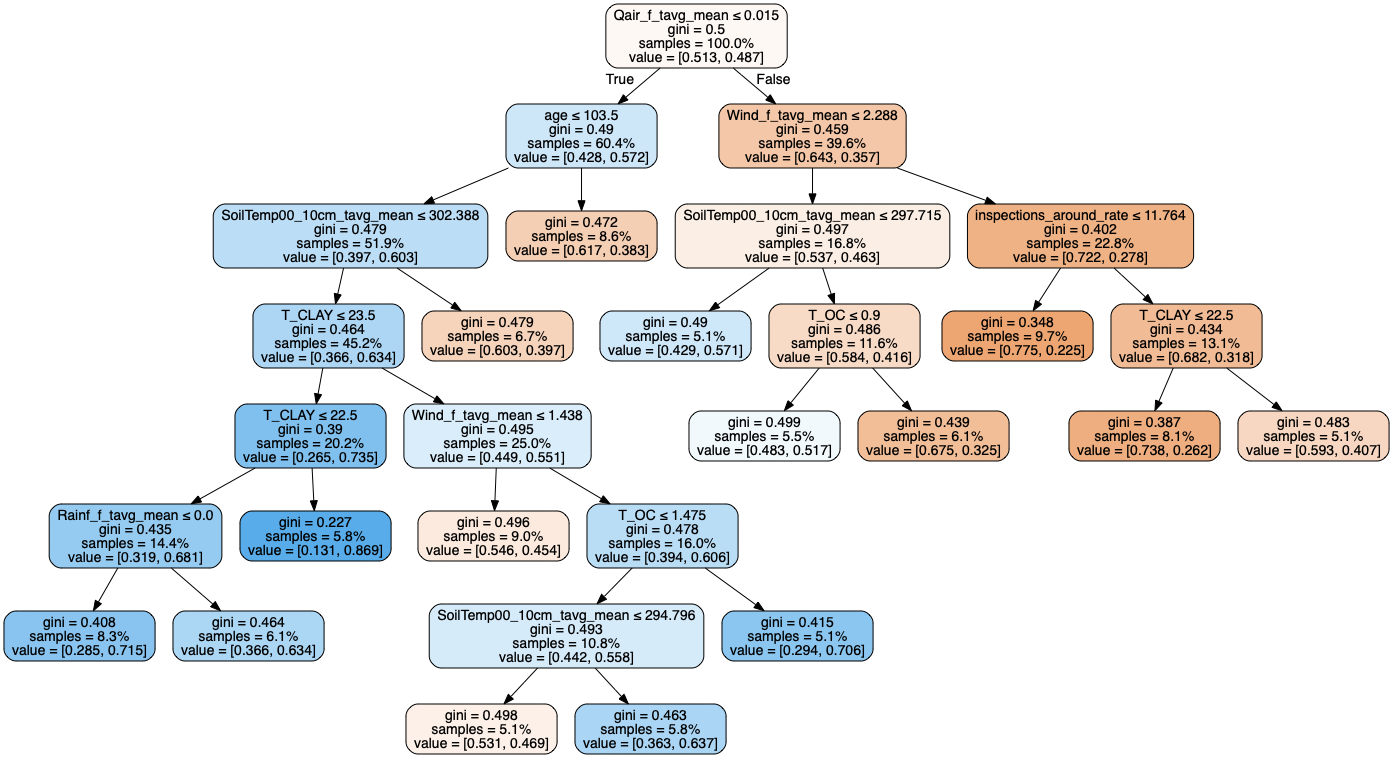

In [38]:
#Visualizing the Decision Tree:

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                proportion=True,
                feature_names=faw_finaltree.drop('target', axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Here we write some code for the graphics:

14.13208327588584
85.86791672411415


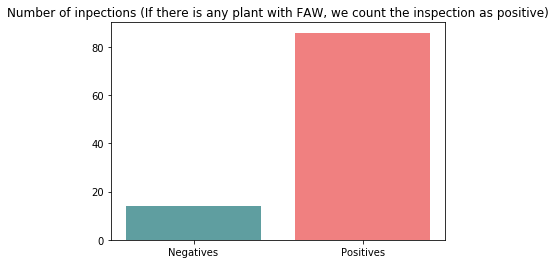

In [39]:
with open('data/faw20191220_targetpercent.pickle', 'rb') as input:
    faw_bin = pickle.load(input)
faw_bin = faw_bin[faw_bin.cropMain == 'maize']
faw_bin['instant_yearly'] = (pd.to_datetime(faw_bin.date, format = '%Y%m%d') - pd.to_datetime('20180101', format = '%Y%m%d')).dt.days# faw.instant.copy()
faw_bin.loc[faw_bin.instant_yearly > 364, 'instant_yearly'] = faw_bin.loc[faw_bin.instant_yearly > 364, 'instant_yearly'] - 365


total = faw_bin.shape[0]
neg = faw_bin[faw_bin.target==0].shape[0]
pos = total - neg
neg_perc = (neg / total) * 100
pos_perc = (pos / total) * 100

# Distribution of binary target (No faw vs any faw)
plt.bar([1, 2], [neg_perc, pos_perc], tick_label=['Negatives', 'Positives'], color=['cadetblue', 'lightcoral'])
plt.title('Number of inpections (If there is any plant with FAW, we count the inspection as positive)')

print(neg_perc)
print(pos_perc)

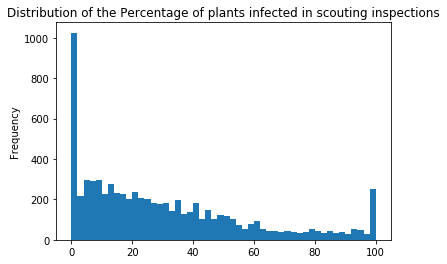

In [40]:
# Distribution of the continuous target (percentage of plants where faw was detected during the scouting inspection)
faw_bin.target.plot.hist(bins=50, title='Distribution of the Percentage of plants infected in scouting inspections')

Text(0.5, 0, 'Month')

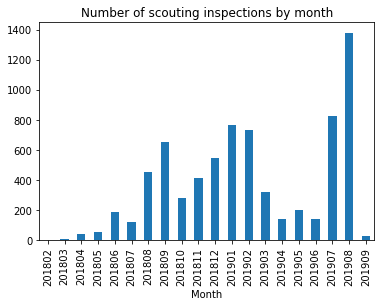

In [41]:
# Number of scouting inspections by month
ax = faw_bin.groupby(faw_bin.date.str.slice(0, 6)).count().date.plot.bar(title='Number of scouting inspections by month')
ax.set_xlabel('Month')

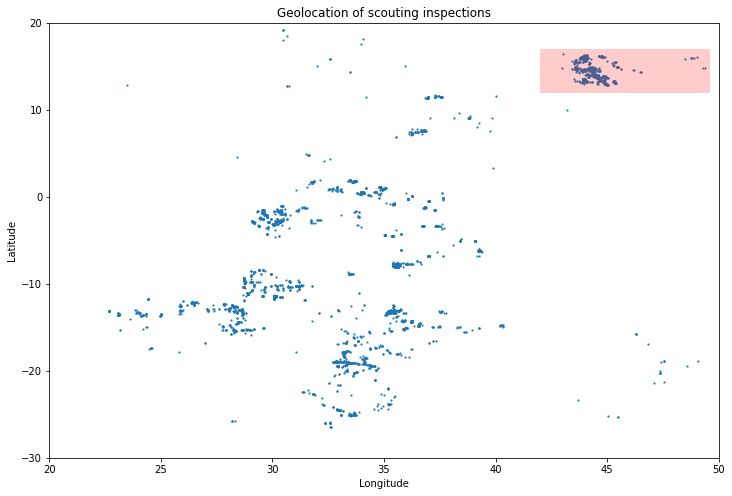

In [42]:


# Scouting inspection plot by latitude longitude:
ax = faw_bin.plot(kind='scatter', x='longitude_x', y='latitude_x',
              figsize=(12,8), marker='.', s=5, xlim=(20, 50), ylim=(-30, 20),
              title='Geolocation of scouting inspections'
             )
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.add_patch(Rectangle((42, 12), 7.6, 5,
                       alpha=0.2, facecolor='red'))

Text(0.5, 0, 'Month')

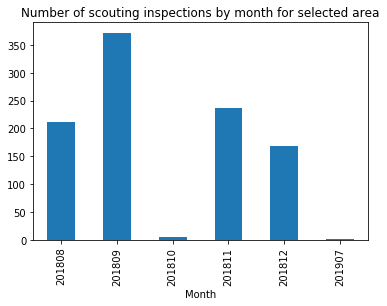

In [43]:
# Number of scouting inspections by month for specific area
ax = faw_bin[(faw_bin.latitude_x > 12) & (faw_bin.longitude_x > 42)].groupby(faw_bin.date.str.slice(0, 6)).count().date.plot.bar(
    title='Number of scouting inspections by month for selected area')
ax.set_xlabel('Month')


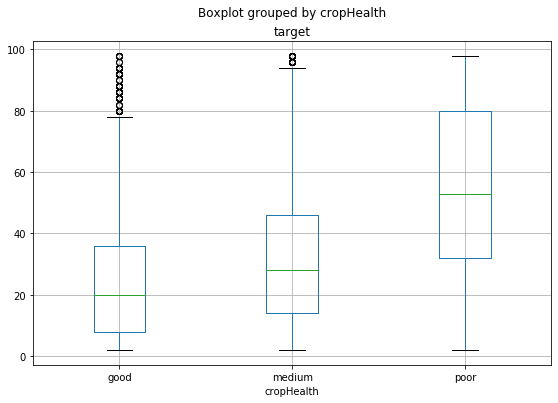

In [44]:
faw.boxplot(column='target', by='cropHealth', figsize=(9, 6))

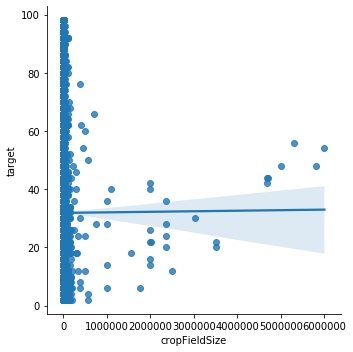

In [45]:

sns.lmplot(x='cropFieldSize', y='target', data=faw[faw.cropFieldSize < 10000000], fit_reg=True) 

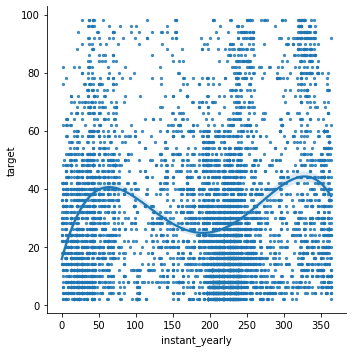

In [46]:

sns.lmplot(x='instant_yearly', y='target', data=faw, fit_reg=True, order=4, scatter_kws={"s": 5}) 

Text(0.5, 0, 'Month')

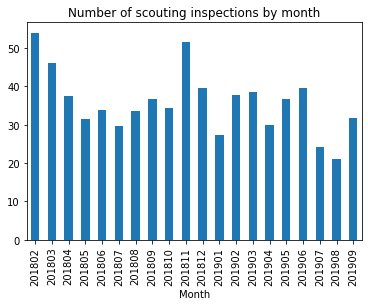

In [47]:
# Number of scouting inspections by month
ax = faw.groupby(faw.date.str.slice(0, 6)).mean().target.plot.bar(title='Number of scouting inspections by month')
ax.set_xlabel('Month')

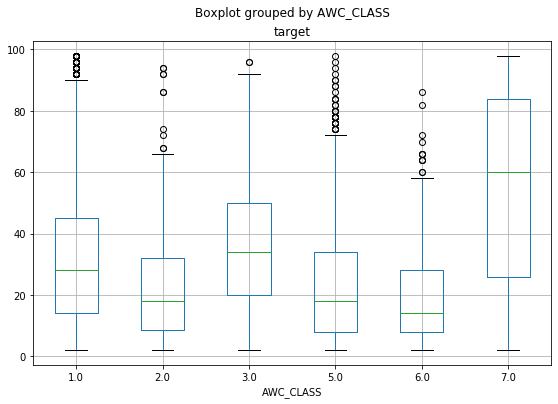

In [48]:
faw.boxplot(column='target', by='AWC_CLASS', figsize=(9, 6))

Text(0.5, 1, 'Third order regression function')

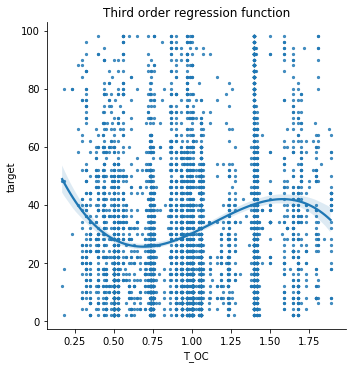

In [49]:


sns.lmplot(x='T_OC', y='target', data=faw[faw.T_OC <= 2], fit_reg=True, order=3, scatter_kws={"s": 5})
plt.title('Third order regression function')

Text(0.5, 1, 'All inspections')

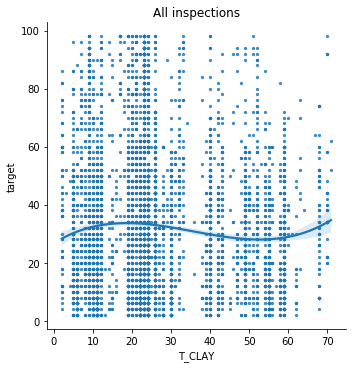

In [50]:

sns.lmplot(x='T_CLAY', y='target', data=faw[faw.T_CLAY < 75], fit_reg=True, order=3, scatter_kws={"s": 5})
plt.title('All inspections')

Text(0.5, 1, 'Only inspections after a week with an average atmospheric pressure under 96627.656 Pa\n')

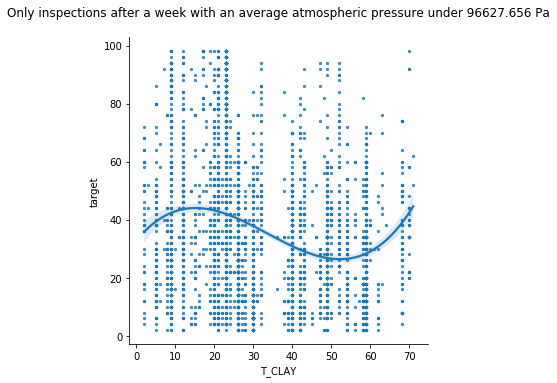

In [51]:

sns.lmplot(x='T_CLAY', y='target', data=faw[faw.Psurf_f_tavg_mean <= 96627.656], fit_reg=True, order=3, scatter_kws={"s": 5})
plt.title('Only inspections after a week with an average atmospheric pressure under 96627.656 Pa\n')

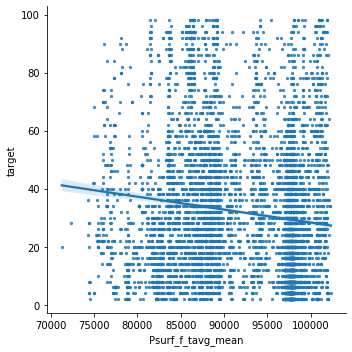

In [52]:

sns.lmplot(x='Psurf_f_tavg_mean', y='target', data=faw, fit_reg=True, order=1, scatter_kws={"s": 5})

Text(0.5, 1, 'First order regression function')

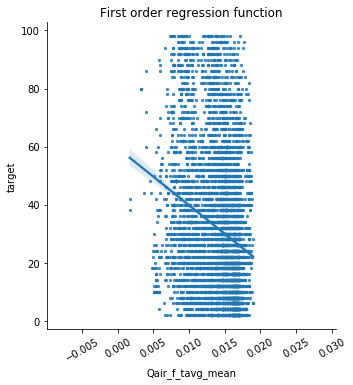

In [53]:

g = sns.lmplot(x='Qair_f_tavg_mean', y='target', data=faw, fit_reg=True, order=1, scatter_kws={"s": 5})
g.set_xticklabels(rotation=30)
plt.title('First order regression function')

Text(0.5, 1, 'Second order regression function')

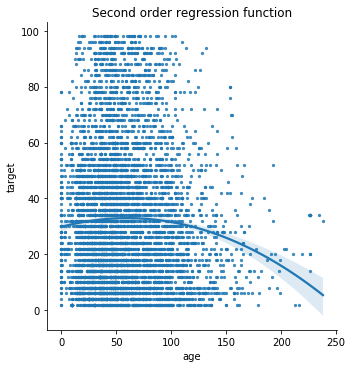

In [54]:

sns.lmplot(x='age', y='target', data=faw[faw.age < 300], fit_reg=True, order=2, scatter_kws={"s": 5})
plt.title('Second order regression function')

Text(0.5, 1, 'First order regression function')

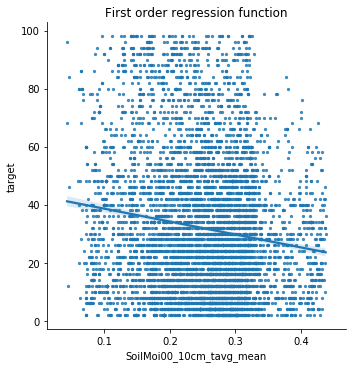

In [55]:

sns.lmplot(x='SoilMoi00_10cm_tavg_mean', y='target', data=faw, fit_reg=True, order=1, scatter_kws={"s": 5})
plt.title('First order regression function')

Text(0.5, 1, 'Third order regression function')

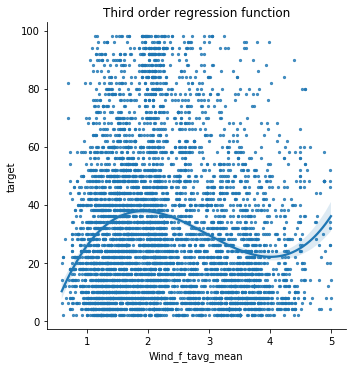

In [56]:

sns.lmplot(x='Wind_f_tavg_mean', y='target', data=faw[faw.Wind_f_tavg_mean < 5], fit_reg=True, order=3, scatter_kws={"s": 5})
plt.title('Third order regression function')

Text(0.5, 1, 'Second order regression function')

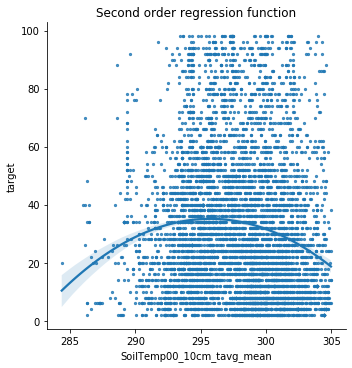

In [57]:

sns.lmplot(x='SoilTemp00_10cm_tavg_mean', y='target', data=faw[faw.SoilTemp00_10cm_tavg_mean < 305], fit_reg=True, order=2, scatter_kws={"s": 5})
plt.title('Second order regression function')

Text(0.5, 1, 'First order regression function')

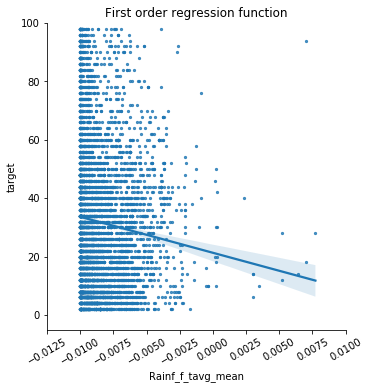

In [58]:

g = sns.lmplot(x='Rainf_f_tavg_mean', y='target', data=faw, fit_reg=True, order=1, scatter_kws={"s": 5})
g.set(xlim=(-0.0001, 0.0008))
g.set(ylim=(-5, 100))
g.set_xticklabels(rotation=30)
plt.title('First order regression function')


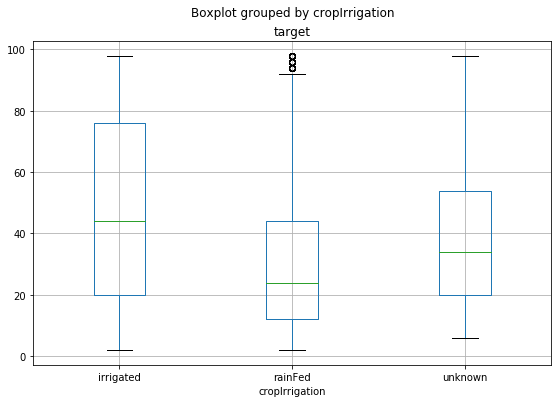

In [59]:
faw.boxplot(column='target', by='cropIrrigation', figsize=(9, 6))

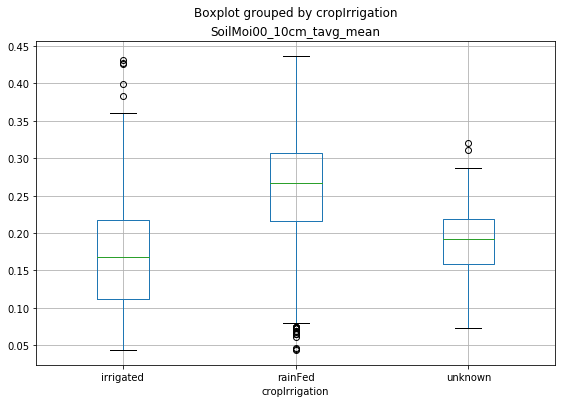

In [60]:
faw.boxplot(column='SoilMoi00_10cm_tavg_mean', by='cropIrrigation', figsize=(9, 6))

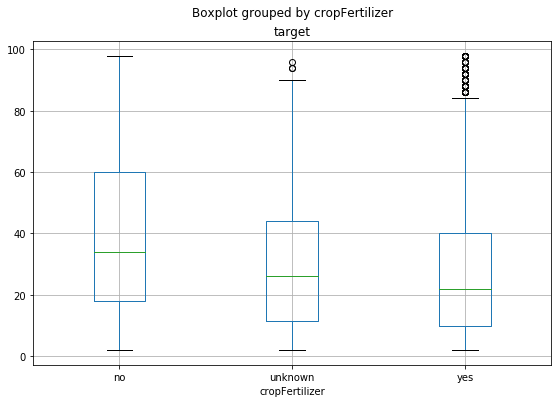

In [61]:
faw.boxplot(column='target', by='cropFertilizer', figsize=(9, 6))

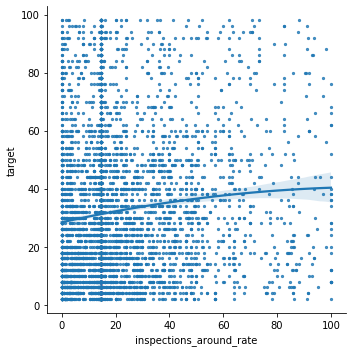

In [62]:

sns.lmplot(x='inspections_around_rate', y='target', data=faw, fit_reg=True, order=2, scatter_kws={"s": 5}) 

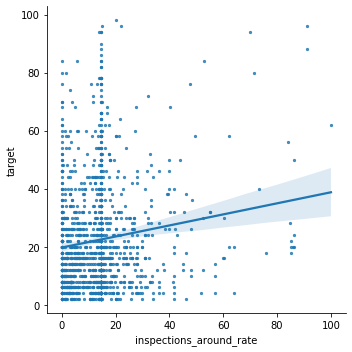

In [63]:

sns.lmplot(x='inspections_around_rate', y='target', data=faw[(faw.Qair_f_tavg_mean > 0.015) & (faw.Wind_f_tavg_mean > 2.288)], fit_reg=True, order=1, scatter_kws={"s": 5})

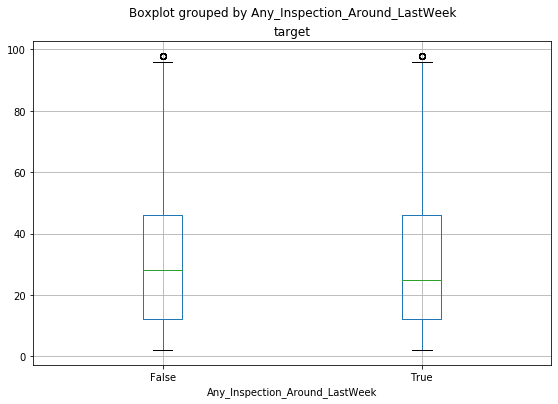

In [64]:
auxdf = faw.copy()
auxdf['Any_Inspection_Around_LastWeek'] = auxdf.inspections_around_count > 0

auxdf.boxplot(column='target', by='Any_Inspection_Around_LastWeek', figsize=(9, 6))

Text(0.5, 1.0, 'Number of inpections (If there is any plant with FAW, we count the inspection as positive)')

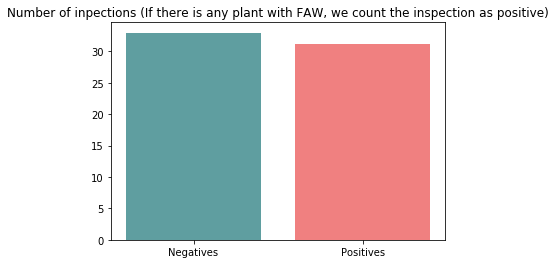

In [65]:
neg = auxdf.target[~auxdf.Any_Inspection_Around_LastWeek].mean()
pos = auxdf.target[auxdf.Any_Inspection_Around_LastWeek].mean()


# Distribution of binary target (No faw vs any faw)
plt.bar([1, 2], [neg, pos], tick_label=['Negatives', 'Positives'], color=['cadetblue', 'lightcoral'])
plt.title('Number of inpections (If there is any plant with FAW, we count the inspection as positive)')